In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import tree, preprocessing
import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split

import geopandas as gpd

<Axes: >

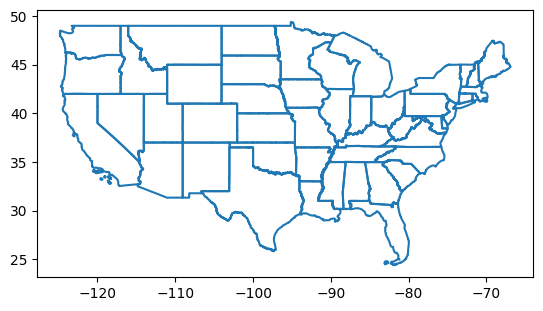

In [3]:
usa = gpd.read_file('map_usa/tl_2022_us_state.shp')
non_continental = ['HI','VI','MP','GU','AK','AS','PR']
for n in non_continental:
    usa = usa[usa.STUSPS != n]
usa.boundary.plot()


In [3]:
california = usa[usa.STUSPS == 'CA']

In [4]:
filepath = "data/fire_archive_SV-C2_390000.shp"

gdf = gpd.read_file(filepath, engine='pyogrio')

In [14]:
# gdf_2015 = gdf[gdf['ACQ_DATE'].str.contains('2015')]

def get_year(timestamp):
    return timestamp.year

gdf_2015 = gdf[gdf['ACQ_DATE'].apply(get_year) == 2015]

In [15]:
# Add a observation ID column
gdf_2015['observation_id'] = range(len(gdf_2015))

/home/gdrtodd/miniconda3/envs/wildfires/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [16]:
gdf_2015

,LATITUDE,LONGITUDE,BRIGHTNESS,SCAN,TRACK,ACQ_DATE,ACQ_TIME,SATELLITE,INSTRUMENT,CONFIDENCE,VERSION,BRIGHT_T31,FRP,DAYNIGHT,TYPE,geometry,observation_id
1306783,40.751339,-81.441330,335.88,0.45,0.63,2015-01-01,0630,N,VIIRS,n,1,264.78,3.99,N,0,POINT (-81.44133 40.75134),0
1306784,39.937538,-76.812614,301.80,0.51,0.49,2015-01-01,0630,N,VIIRS,n,1,267.25,0.80,N,2,POINT (-76.81261 39.93754),1
1306785,40.126335,-80.997078,322.99,0.42,0.61,2015-01-01,0630,N,VIIRS,n,1,265.49,3.26,N,0,POINT (-80.99708 40.12633),2
1306786,38.956635,-81.926811,296.65,0.47,0.64,2015-01-01,0630,N,VIIRS,n,1,265.54,1.06,N,0,POINT (-81.92681 38.95663),3
1306787,38.950653,-81.927086,295.98,0.47,0.64,2015-01-01,0630,N,VIIRS,n,1,264.12,1.06,N,0,POINT (-81.92709 38.95065),4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1883900,34.279835,-109.076752,341.52,0.43,0.46,2015-12-31,2042,N,VIIRS,n,1,283.17,5.39,D,0,POINT (-109.07675 34.27983),577117
1883901,35.962158,-112.155090,342.05,0.48,0.40,2015-12-31,2042,N,VIIRS,n,1,276.36,5.56,D,0,POINT (-112.15509 35.96216),577118
1883902,35.965832,-112.155701,338.68,0.48,0.40,2015-12-31,2042,N,VIIRS,n,1,274.28,7.17,D,0,POINT (-112.15570 35.96583),577119
1883903,35.651077,-120.605408,334.89,0.48,0.40,2015-12-31,2042,N,VIIRS,n,1,288.17,4.90,D,0,POINT (-120.60541 35.65108),577120


In [17]:
perimeters = gpd.read_file('data/perimeters/US_HIST_FIRE_PERIM_2015_DD83.shp')

In [43]:
perimeters.columns

Index(['FID', 'agency', 'comments', 'active', 'mapmethod', 'datecurren',
       'uniquefire', 'fireyear', 'incidentna', 'pooownerun', 'perimeterd',
       'gisacres', 'complexnam', 'firecode', 'complexpar', 'poorespons',
       'state', 'inciwebid', 'localincid', 'irwinid', 'incomplex',
       'complexfir', 'latest', 'SHAPE_Leng', 'SHAPE_Area', 'geometry'],
      dtype='object')

In [18]:
from datetime import datetime, timedelta

check_df_1 = perimeters['datecurren'].dropna()
check_df_2 = perimeters['perimeterd'].dropna()

full = check_df_1.astype(str).apply(lambda x: datetime.strptime(x,'%Y-%m-%d')) -  check_df_2.astype(str).apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))


In [19]:
print(gdf_2015.crs)
print(perimeters.crs)

EPSG:4326
EPSG:4326


In [34]:
joined = gpd.sjoin(gdf_2015, perimeters, how="inner", op="within")


/home/gdrtodd/miniconda3/envs/wildfires/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [21]:
joined.columns

Index(['LATITUDE', 'LONGITUDE', 'BRIGHTNESS', 'SCAN', 'TRACK', 'ACQ_DATE',
       'ACQ_TIME', 'SATELLITE', 'INSTRUMENT', 'CONFIDENCE', 'VERSION',
       'BRIGHT_T31', 'FRP', 'DAYNIGHT', 'TYPE', 'geometry', 'observation_id',
       'index_right', 'FID', 'agency', 'comments', 'active', 'mapmethod',
       'datecurren', 'uniquefire', 'fireyear', 'incidentna', 'pooownerun',
       'perimeterd', 'gisacres', 'complexnam', 'firecode', 'complexpar',
       'poorespons', 'state', 'inciwebid', 'localincid', 'irwinid',
       'incomplex', 'complexfir', 'latest', 'SHAPE_Leng', 'SHAPE_Area'],
      dtype='object')

In [35]:
joined['ACQ_TIME'] = joined['ACQ_TIME'].astype(str).str.zfill(4)
joined['ACQ_TIME'] = joined['ACQ_TIME'].str[:2] + ':' + joined['ACQ_TIME'].str[2:]
joined['ACQ_DATE'] = joined['ACQ_DATE'].astype(str)

joined['date_time'] = pd.to_datetime(joined['ACQ_DATE'] + ' ' + joined['ACQ_TIME'])

In [27]:
# Determine how many observations don't fall within any of our perimeters
unused_observations = set(gdf_2015['observation_id']) - set(joined['observation_id'])
used_observations = set(joined['observation_id'])

Text(0.5, 1.0, 'Confidence Ratings for Points in Perimeters')

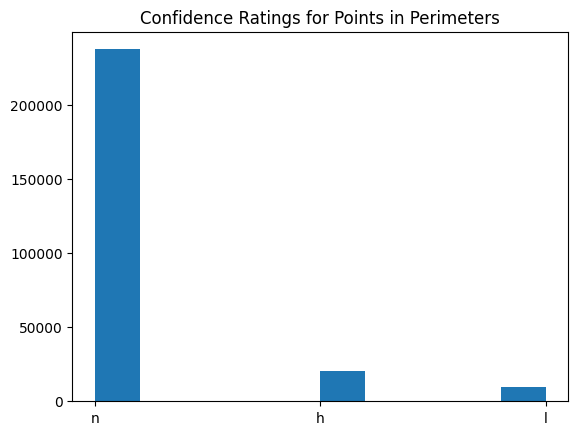

In [28]:
fig, ax = plt.subplots()
ax.hist(gdf_2015[gdf_2015['observation_id'].isin(used_observations)]['CONFIDENCE'])
plt.title("Confidence Ratings for Points in Perimeters")

Text(0.5, 1.0, 'Confidence Ratings for Points *not* in Perimeters')

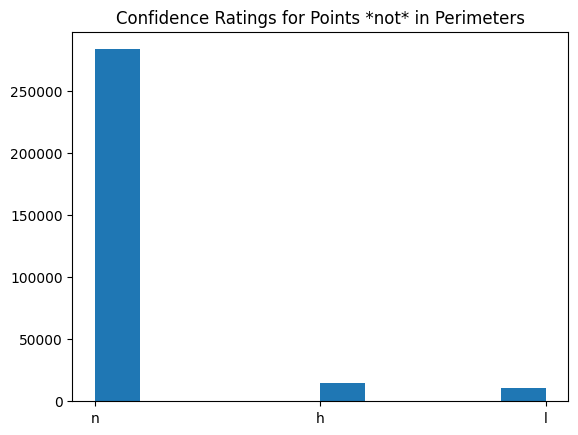

In [29]:
fig, ax = plt.subplots()
ax.hist(gdf_2015[gdf_2015['observation_id'].isin(unused_observations)]['CONFIDENCE'])
plt.title("Confidence Ratings for Points *not* in Perimeters")

## Code for filtering based on temporal alignment

In [111]:
# Record the weighted average of the times for all observations within a specified perimeter
def get_observation_datetimes_within_perimiter(fire_id):
    return joined[joined['FID'] == fire_id]['date_time']

average_observation_day_by_perimeter = {}
for perimeter in joined["FID"].unique():
    date_times = get_observation_datetimes_within_perimiter(perimeter)
    value_counts = date_times.value_counts()
    average_obs_day = (value_counts.index.day_of_year * value_counts).sum() / value_counts.sum()

    average_observation_day_by_perimeter[perimeter] = average_obs_day
    

In [128]:
# Record the date_time of each observation (in a dict for easy access)
def obs_to_date_time(row):
    return (row['observation_id'], row['date_time'])

observation_id_to_date_time = dict(list(joined.apply(obs_to_date_time, axis=1).values))

In [145]:
# Record the set of all perimeters that surround each observation (again in a dict)
observation_id_to_perimeters = joined.groupby("observation_id")["FID"].apply(list).to_dict()

In [156]:
def find_temporally_closest_perimeter(observation_id):
    observation_date_time = observation_id_to_date_time[observation_id]

    possible_perimeters = observation_id_to_perimeters[observation_id]

    best_avg_time_delta = 1000 # in days
    best_perimeter_id = None

    for perimeter_id in possible_perimeters:

        average_obs_day = average_observation_day_by_perimeter[perimeter_id]

        avg_time_delta = abs(observation_date_time.day_of_year - average_obs_day)

        if avg_time_delta < best_avg_time_delta:
            best_avg_time_delta = avg_time_delta
            best_perimeter_id = perimeter_id

    return best_perimeter_id

In [ ]:
# Filter the joined dataset to only rows in which the observation temporally matches the perimeter
filtered_to_closest = joined[joined["observation_id"].apply(find_temporally_closest_perimeter) == joined["FID"]]

In [163]:
filtered_to_closest

,LATITUDE,LONGITUDE,BRIGHTNESS,SCAN,TRACK,ACQ_DATE,ACQ_TIME,SATELLITE,INSTRUMENT,CONFIDENCE,...,state,inciwebid,localincid,irwinid,incomplex,complexfir,latest,SHAPE_Leng,SHAPE_Area,date_time
1738483,45.311413,-116.195427,295.88,0.56,0.52,2015-08-26,09:06,N,VIIRS,n,...,ID,4506,000192,{D1D2845B-5031-44EF-8CC6-BD7827E67E2F},N,None,N,2.792842,0.044497,2015-08-26 09:06:00
1738485,45.306675,-116.196747,334.38,0.56,0.52,2015-08-26,09:06,N,VIIRS,n,...,ID,4506,000192,{D1D2845B-5031-44EF-8CC6-BD7827E67E2F},N,None,N,2.792842,0.044497,2015-08-26 09:06:00
1738486,45.306286,-116.190536,323.74,0.56,0.52,2015-08-26,09:06,N,VIIRS,n,...,ID,4506,000192,{D1D2845B-5031-44EF-8CC6-BD7827E67E2F},N,None,N,2.792842,0.044497,2015-08-26 09:06:00
1738487,45.301922,-116.197975,331.71,0.56,0.52,2015-08-26,09:06,N,VIIRS,n,...,ID,4506,000192,{D1D2845B-5031-44EF-8CC6-BD7827E67E2F},N,None,N,2.792842,0.044497,2015-08-26 09:06:00
1738488,45.301540,-116.191849,331.44,0.56,0.52,2015-08-26,09:06,N,VIIRS,n,...,ID,4506,000192,{D1D2845B-5031-44EF-8CC6-BD7827E67E2F},N,None,N,2.792842,0.044497,2015-08-26 09:06:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1882982,34.295246,-119.340538,356.86,0.43,0.46,2015-12-26,09:18,N,VIIRS,n,...,CA,None,089187,{FE6E92F8-770E-49A0-BFFF-B2133455598B},N,None,Y,0.132328,0.000510,2015-12-26 09:18:00
1882983,34.294781,-119.335823,367.00,0.43,0.46,2015-12-26,09:18,N,VIIRS,h,...,CA,None,089187,{FE6E92F8-770E-49A0-BFFF-B2133455598B},N,None,Y,0.132328,0.000510,2015-12-26 09:18:00
1882985,34.290577,-119.336586,343.29,0.43,0.46,2015-12-26,09:18,N,VIIRS,n,...,CA,None,089187,{FE6E92F8-770E-49A0-BFFF-B2133455598B},N,None,Y,0.132328,0.000510,2015-12-26 09:18:00
1883027,34.302914,-119.335327,332.09,0.52,0.41,2015-12-26,20:36,N,VIIRS,n,...,CA,None,089187,{FE6E92F8-770E-49A0-BFFF-B2133455598B},N,None,Y,0.132328,0.000510,2015-12-26 20:36:00


ConversionError: Failed to convert value(s) to axis units: '2015-09-13'

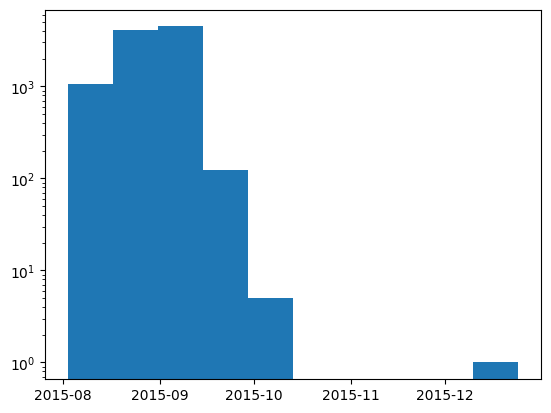

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# joined[joined['FID'] == 13][['date_time']].hist(ax=ax, log=True)
ax.hist(joined[joined['FID'] == 13][['date_time']], log=True)
# add vertical line at perimeter date
plt.axvline(x=perimeters[perimeters['FID'] == 13]['perimeterd'].iloc[0], color='k', linestyle='--')

plt.show()

In [80]:
joined['FID']

775602      138
1113520     138
1113521     138
1113522     138
1113523     138
           ... 
1349088    7454
1349089    7454
1349091    7454
1349133    7454
1349135    7454
Name: FID, Length: 6636309, dtype: int64

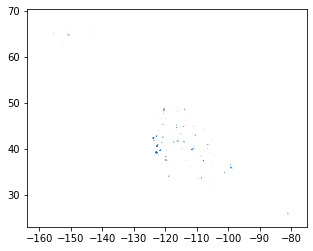

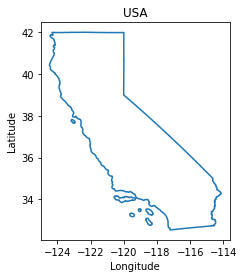

In [24]:
perimeters.plot()
california.boundary.plot()
plt.title('USA')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

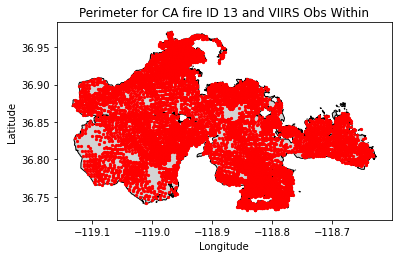

In [76]:
fid = 13

specific_perimeter = perimeters[perimeters['FID'] == fid]

points_within = joined[joined['FID'] == fid]

fig, ax = plt.subplots()

specific_perimeter.plot(ax=ax, color='lightgray', edgecolor='black')

points_within.plot(ax=ax, markersize=5, color='red')

plt.title(f"Perimeter for CA fire ID {fid} and VIIRS Obs Within")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()


<AxesSubplot:>

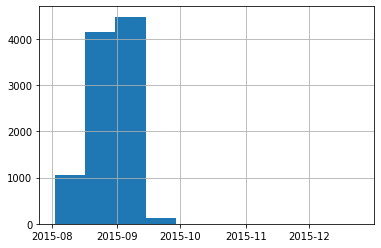

In [75]:
# hist plot of the date_time columns
points_within.date_time.hist()

In [9]:
def efficient_filter(group):
    # Sort group by date_time
    group = group.sort_values('date_time')
    
    # Calculate difference with the next and previous date for each row
    diff_next = group['date_time'].diff(-1).abs().dt.days
    diff_prev = group['date_time'].diff().abs().dt.days
    
    # Check if the time difference is within the threshold (5 days in this case)
    within_threshold = ((diff_next <= 5) | (diff_prev <= 5))
    
    return group[within_threshold]

# Group by FID and apply the efficient_filter function
filtered_df = joined.groupby('FID').apply(efficient_filter)

# Reset the index of the result
filtered_df = filtered_df.reset_index(drop=True)


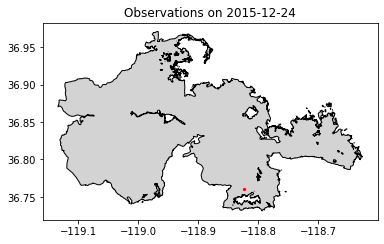

In [79]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

days = points_within['date_time'].dt.date.unique()

fig, ax = plt.subplots()

specific_perimeter.plot(ax=ax, color='lightgray', edgecolor='black')

def animate(day):
    ax.clear()
    
    specific_perimeter.plot(ax=ax, color='lightgray', edgecolor='black')
    
    day_points = points_within[points_within['date_time'].dt.date == day]
    day_points.plot(ax=ax, markersize=5, color='red')
    
    ax.set_title(f"Observations on {day}")

ani = animation.FuncAnimation(fig, animate, frames=days, repeat=False, interval=1000)

ani.save('animated_fire_obs.gif', writer='pillow', fps=1)

